# import libraries

In [1]:
# import libraries
import numpy as np
import pandas as pd

# import dataset

In [2]:
# import dataset
insurance_df = pd.read_csv('insurance.csv')

# make a copy of the original dataset
insurance = insurance_df.copy()

In [3]:
# initial look at the data
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
# basic info about the data
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
# basisc statistical details about the data
insurance.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [6]:
#  basic statistical details about categorical columns
insurance.describe(include='O').transpose()

,count,unique,top,freq
sex,1338,2,male,676
smoker,1338,2,no,1064
region,1338,4,southeast,364


In [7]:
# list catagorical unique values
for col in insurance.select_dtypes(include='object'):
    print(f'{col} : {insurance[col].unique()}')

sex : ['female' 'male']
smoker : ['yes' 'no']
region : ['southwest' 'southeast' 'northwest' 'northeast']


# data cleaning

In [8]:
# check for missing values
insurance.isnull().sum()

# at this point, no furthre cleaning is required as there are no missing values or duplicates

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

# data modeling

In [9]:
### Define basic problem
# Can customer characteristics predict their region accurately?
# Which factors (age, BMI, smoking status, children) are most influential in distinguishing regions?
# Are smokers more concentrated in specific regions?
# split features and target
X = insurance.drop('region', axis=1)
y = insurance['region']

In [10]:
# catagorical variable onehot encoding excpet for target variable
X = pd.get_dummies(X, drop_first=True)

# numerical feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [11]:
# split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42, stratify=y)

In [12]:
# model training_multinomial logistic regression
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
log_reg.fit(X_train, y_train)   

c:\Users\samib\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

# model prediction

In [13]:
# model prediction
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)

# model evaluation

In [14]:
# model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

In [15]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Confusion Matrix:
 [[ 5 43 26  7]
 [14 30 33  5]
 [ 7 14 63  7]
 [ 3 28 44  6]]


In [16]:
# classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

   northeast       0.17      0.06      0.09        81
   northwest       0.26      0.37      0.30        82
   southeast       0.38      0.69      0.49        91
   southwest       0.24      0.07      0.11        81

    accuracy                           0.31       335
   macro avg       0.26      0.30      0.25       335
weighted avg       0.27      0.31      0.26       335



In [17]:
# accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score:", accuracy)


Accuracy Score: 0.31044776119402984


ROC AUC Score: 0.6005232263912632


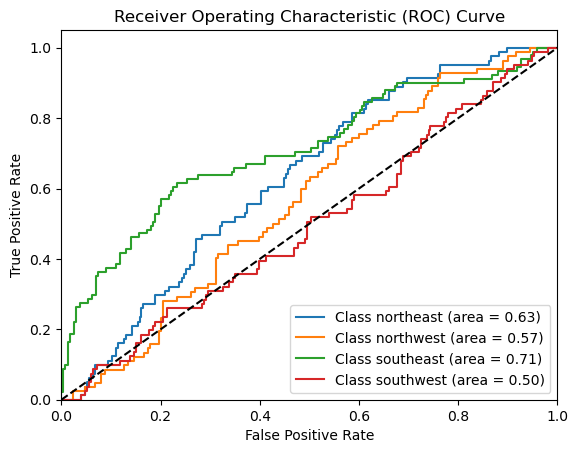

In [18]:
# roc auc score
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print("ROC AUC Score:", roc_auc)
# roc curve plotting for each class
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
y_test_binarized = label_binarize(y_test, classes=log_reg.classes_)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(log_reg.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_prob[:, i])
    plt.plot(fpr[i], tpr[i], label=f'Class {log_reg.classes_[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Genral rule to interpretation of ROC AUC Score:
# 0.5 → Random guessing

# 0.7–0.8 → Good

# 0.8–0.9 → Very good

# 0.9 → Excellent

# model interpretation (odds ratios)

In [19]:
# coefficients interpretation
coefficients = pd.DataFrame(log_reg.coef_, columns=X.columns, index=log_reg.classes_)
print("Logistic Regression Coefficients:\n", coefficients)

# Positive coefficients increase the log-odds of the outcome (smoker = 1)
# Negative coefficients decrease the log-odds of the outcome (smoker = 0)


Logistic Regression Coefficients:
                 age       bmi  children   charges  sex_male  smoker_yes
northeast -0.078919 -0.228025 -0.030365  0.289529  0.018092   -0.235974
northwest  0.073685 -0.247794  0.026181 -0.055626  0.026579   -0.043322
southeast  0.027784  0.484457 -0.034217 -0.253968 -0.002008    0.310620
southwest -0.022550 -0.008637  0.038401  0.020065 -0.042662   -0.031324


# feature importance

C:\Users\samib\AppData\Local\Temp\ipykernel_31404\3008310512.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=importance_df, palette='viridis')


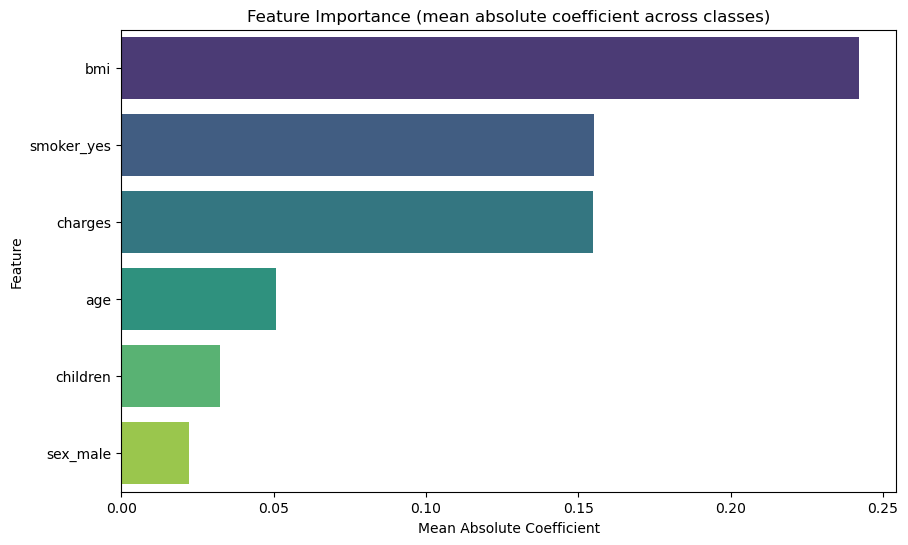

In [21]:
# feature importance visualization
import seaborn as sns

# compute mean absolute coefficient per feature across classes (importance)
importance = coefficients.abs().mean(axis=0).sort_values(ascending=False)
importance_df = importance.reset_index()
importance_df.columns = ['Feature', 'Coefficient']
plt.figure(figsize=(10,6))
sns.barplot(x='Coefficient', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance (mean absolute coefficient across classes)')
plt.xlabel('Mean Absolute Coefficient')
plt.ylabel('Feature')
plt.show()

